In [1]:
using Random
using Plots

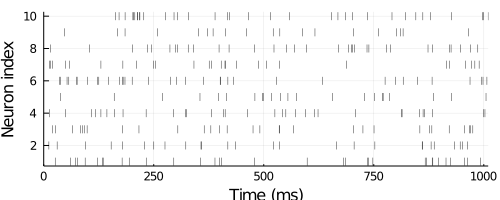

In [2]:
Random.seed!(0) # set random seed

T = 1000 # ms
dt = 1f0 # ms
nt = Int32(T/dt) # number of timesteps

n_neurons = 10 # ニューロンの数
fr = 30 # ポアソンスパイクの発火率(Hz)

isi = 1/(fr*dt*1e-3) * randexp(Int32(nt*1.5/fr), n_neurons)
spike_time = cumsum(isi, dims=1) # ISIを累積

# raster plot
p = plot(xlabel ="Time (ms)", ylabel="Neuron index", xlim =(0, T+10), legend=false, size=(500, 200))
for i=1:n_neurons
    scatter!(p, spike_time[:, i], i*ones(Int32(nt*1.5/fr)), shape=:vline, color="black")
end
display(p)

In [3]:
spike_time[spike_time .> nt - 1] .= 1 # ntを超える場合を1に
spike_time = round.(Int32, spike_time) # float to int
spikes = zeros(Bool, nt, n_neurons) # スパイク記録変数

for i=1:n_neurons    
    spikes[spike_time[:, i], i] .= 1
end

spikes[1] = 0 # (spike_time=1)の発火を削除
println("Num. of spikes : ", sum(spikes))
println("Firing rate : ", sum(spikes)/(n_neurons*T)*1e3, "Hz")

Num. of spikes : 293
Firing rate : 29.3Hz


In [4]:
Random.seed!(0) # set random seed

T = 1000 # ms
dt = 1f0 # ms
nt = Int32(T/dt) # number of timesteps

n_neurons = Int32(10) # ニューロンの数
fr = 30 # ポアソンスパイクの発火率(Hz)

spikes = rand(nt, n_neurons) .< fr*dt*1e-3

println("Num. of spikes : ", sum(spikes))
println("Firing rate : ", sum(spikes)/(n_neurons*T)*1e3, "Hz")

Num. of spikes : 304
Firing rate : 30.4Hz


In [5]:
function rasterplot(spikes, plotsize=(500, 200))
    # input spike -> time, #neurons
    spike_inds = Tuple.(findall(x -> x > 0, spikes))
    spike_time = first.(spike_inds)
    neuron_inds = last.(spike_inds)
    
    # raster plot
    scatter(spike_time, neuron_inds,
        xlabel ="Time (ms)", ylabel="Neuron index",
        shape=:vline, color="black",
        legend=false, size=plotsize)
end

rasterplot (generic function with 2 methods)

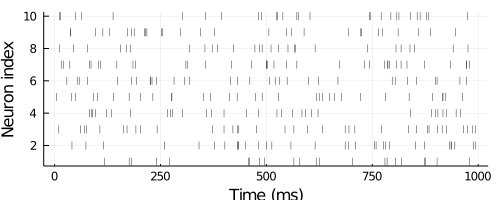

In [6]:
rasterplot(spikes)

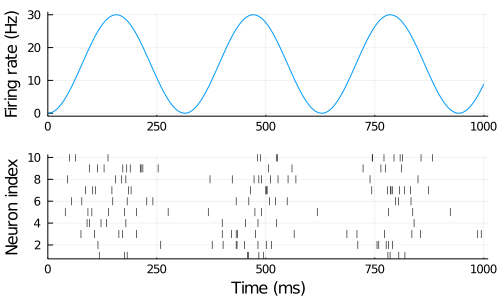

In [7]:
Random.seed!(0) # set random seed

T = 1000 # ms
dt = 1f0 # ms
nt = Int32(T/dt) # number of timesteps

n_neurons = Int32(10) # ニューロンの数

t = Array{Float32}(1:nt)*dt
fr = 30(sin.(1e-2t)).^2 # ポアソンスパイクの発火率(Hz)

spikes = rand(nt, n_neurons) .< fr*dt*1e-3

p1 = plot(t, fr, ylabel ="Firing rate (Hz)", legend=false)
p2 = rasterplot(spikes)
plot(p1, p2, xlim=(0, T+10), layout = grid(2, 1, heights=[0.5, 0.5]), size=(500,300))

In [8]:
Random.seed!(0) # set random seed

T = 1000 # ms
dt = 1f0 # ms
nt = Int32(T/dt) # number of timesteps
tref = 5f0 # 不応期 (ms)

n_neurons = Int32(10) # ニューロンの数
fr = 30 # ポアソンスパイクの発火率(Hz)

tlast = zeros(n_neurons) # 発火時刻の記録変数
spikes = zeros(nt, n_neurons)

# simulation
@time for i=1:nt
    fire = rand(n_neurons) .< fr*dt*1e-3
    spikes[i, :] = ((dt*i) .> (tlast .+ tref)) .* fire
    tlast[:] = tlast .* (1 .- fire) + dt*i * fire # 発火時刻の更新
end

println("Num. of spikes : ", sum(spikes))
println("Firing rate : ", sum(spikes)/(n_neurons*T)*1e3, "Hz")

  0.438333 seconds (1.65 M allocations: 91.384 MiB, 3.89% gc time, 98.86% compilation time)
Num. of spikes : 267.0
Firing rate : 26.700000000000003Hz


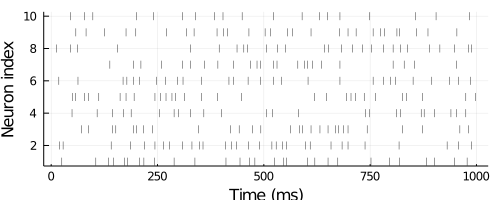

In [9]:
rasterplot(spikes)

In [10]:
using Distributions 

In [11]:
function GammaSpike(T, dt, n_neurons, fr, k)
    nt = Int32(T/dt) # number of timesteps
    theta = 1/(k*(fr*dt*1e-3)) # fr = 1/(k*theta)

    isi = rand(Gamma(k, theta), Int32(round(nt*1.5/fr)), n_neurons)
    spike_time = cumsum(isi, dims=1) # ISIを累積

    spike_time[spike_time .> nt - 1] .= 1 # ntを超える場合を1に
    spike_time = round.(Int32, spike_time) # float to int
    spikes = zeros(Bool, nt, n_neurons) # スパイク記録変数

    for i=1:n_neurons    
        spikes[spike_time[:, i], i] .= 1
    end

    spikes[1] = 0 # (spike_time=1)の発火を削除
    return spikes
end

GammaSpike (generic function with 1 method)

In [12]:
Random.seed!(0) # set random seed

T = 1000 # ms
dt = 1f0 # ms
nt = Int32(T/dt) # number of timesteps

n_neurons = 10 # ニューロンの数
fr = 30 # ガンマスパイクの発火率(Hz)

# k=1のときはポアソン過程に一致
spikes1 = GammaSpike(T, dt, n_neurons, fr, 1)
spikes2 = GammaSpike(T, dt, n_neurons, fr, 12)

println("Num. of spikes : ", sum(spikes1), ", ",sum(spikes2))
println("Firing rate : ", sum(spikes1)/(n_neurons*T)*1e3, "Hz, ", sum(spikes2)/(n_neurons*T)*1e3, "Hz")

Num. of spikes : 289, 301
Firing rate : 28.9Hz, 30.099999999999998Hz


In [13]:
function GammaISIplot(dt, fr, k, n=1000)
    theta = 1/(k*(fr*dt*1e-3)) # fr = 1/(k*theta)
    isi = rand(Gamma(k, theta), n)
    gamma_pdf = pdf.(Gamma(k, theta), minimum(isi):maximum(isi))

    p = plot(legend=false, xlabel="ISI (ms)", ylabel="Density")
    histogram!(p, isi, normed=true)
    plot!(p, minimum(isi):maximum(isi), gamma_pdf, color="black")
end

GammaISIplot (generic function with 2 methods)

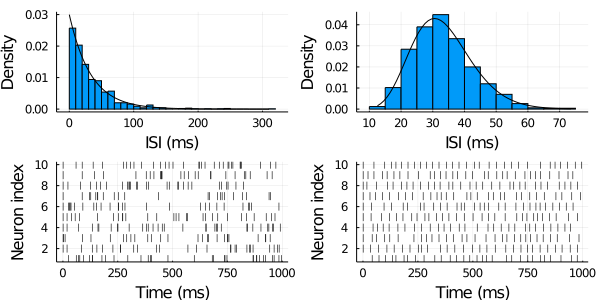

In [14]:
p1 = GammaISIplot(dt, fr, 1)
p2 = GammaISIplot(dt, fr, 12)
p3 = rasterplot(spikes1)
p4 = rasterplot(spikes2)
plot(p1, p2, p3, p4,
    layout = grid(2, 2, widths=[0.5, 0.5], heights=[0.5, 0.5]), legend = false, size=(600, 300))